In [1]:
from encoder import *
from decoder import *
import torchvision

In [4]:
encoder_config = EncoderConfig(
    image_size=224,
    hidden_size=768,
    intermediate_size=3072,
    num_hidden_layers=12,
    num_attention_heads=12,
    num_channels=3,
    patch_size=16,
    layer_norm_eps=1e-6,
    attention_dropout=0.0,
    num_image_tokens=None,
    do_random_mask=True,
    mask_ratio=0.75
)

decoder_config = DecoderConfig(
    image_size=224,
    in_proj_dim=768,
    hidden_size=768,
    intermediate_size=3072,
    num_hidden_layers=12,
    num_attention_heads=12,
    num_channels=3,
    patch_size=16,
    layer_norm_eps=1e-6,
    attention_dropout=0.0
)

In [5]:
encoder = Encoder(encoder_config)
decoder = Decoder(decoder_config)

In [4]:
img = torchvision.io.read_image("dog.jpg")
# resize image to 224x224
img = torchvision.transforms.functional.resize(img, (224, 224)).unsqueeze(0)
# normalize image
img = img / 255.0

In [5]:
img = img.repeat(2, 1, 1, 1)
img.shape

torch.Size([2, 3, 224, 224])

In [26]:
encoder_op, mask, ids_restore = encoder(img)
encoder_op.shape

torch.Size([2, 49, 768])

In [27]:
op = decoder((encoder_op, mask, ids_restore))
op.shape

torch.Size([2, 196, 768])

In [28]:
op = op.view(2, 3, 224, 224)
op.shape

torch.Size([2, 3, 224, 224])

In [29]:
# op = op.view(-1, 14, 14, 16, 16, 3)
# op.shape

In [30]:
# op = op.view(-1, 768, 14, 14)
# op.shape

In [17]:
reverse_patch_embedding = nn.ConvTranspose2d(
    in_channels=768,  # Matches the out_channels of patch_embedding
    out_channels=3,   # Matches the in_channels of patch_embedding (original 3 RGB channels)
    kernel_size=16,   # Same as the kernel_size in patch_embedding
    stride=16,        # Same as the stride in patch_embedding
    padding=0         # No padding in patch_embedding, so use 0 here
)

In [19]:
reverse_path_op = reverse_patch_embedding(op)
reverse_path_op.shape

torch.Size([2, 3, 224, 224])

In [ ]:
torch.clamp()

In [ ]:
# clip the values to be between 0 and 1
reverse_path_op = reverse_path_op.clamp(0, 1)

In [ ]:
torch.sigmoid()

In [35]:
op = op.sigmoid()
op.shape

torch.Size([2, 3, 224, 224])

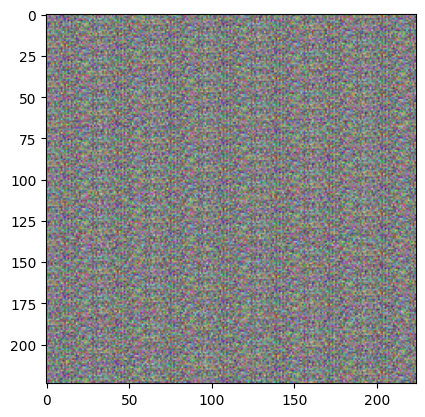

In [36]:
import matplotlib.pyplot as plt

plt.imshow(op[1].detach().cpu().permute(1, 2, 0))

In [ ]:
patch_embedding = nn.Conv2d(
            in_channels=3,
            out_channels=768,
            kernel_size=16,
            stride=16,
            padding="valid", # This indicates no padding is added
        )

In [9]:
from timm.models.vision_transformer import PatchEmbed

In [10]:
patch_embed = PatchEmbed(224, 16, 3, 768)

In [12]:
target = patch_embed(img)
target.shape

torch.Size([2, 196, 768])

In [15]:
loss = torch.nn.MSELoss()(op, target)

In [16]:
loss

tensor(0.4724, grad_fn=<MseLossBackward0>)